In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import time

In [2]:
df = pd.read_csv('churn.csv')

In [3]:
df.shape

(49358, 49)

# Implement a simple neural net

In [4]:
df = np.array(df)
m, n = df.shape
n_df = m
n_test = int(0.2 * m)
np.random.shuffle(df)
scaler = StandardScaler()
df_dev = df[:n_test].T
y_dev = df_dev[-1,:]
X_dev = df_dev[1:n]

df_train = df[n_test:].T
y_train = df_train[-1,:]
X_train = df_train[1:n]
X_train_scaled = scaler.fit_transform(X_train.T)
X_train_scaled = X_train_scaled.T
X_train_scaled.shape

(48, 39487)

In [5]:
def init_param():
    W1 = np.random.randn(10, 48)
    b1 = np.random.randn(10, 1)
    W2 = np.random.randn(1, 10)
    b2 = np.random.randn(1, 1)

    return W1, b1, W2, b2

def ReLu(Z):
    return np.maximum(0, Z)

def sigmoid(Z):
    
    return 1/(1 + np.exp(-Z))

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2

In [6]:
def backward_prop(Z1, A1, Z2, A2, W2, X, Y):
    

    # Calculate gradient of the loss with respect to A2
    dZ2 = A2 - Y
    
    # Calculate gradient of the loss with respect to W2 and b2
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    
    # Backpropagate to hidden layer
    dA1 = np.dot(W2.T, dZ2)
    # Calculate gradient of the loss with respect to Z1
    dZ1 = dA1 * (Z1 > 0)  # Since the derivative of ReLU is 1 if Z1 > 0 else 0
    
    # Calculate gradient of the loss with respect to W1 and b1
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2

In [7]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

def get_prediction(A2):
    return (A2 > 0.5).astype(int)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.mean(predictions == Y)

# Step size scheme

In [8]:
def learningRateDecay(alpha0, decay_rate, n_epoch):

    """
    function: α=(1/(1+decayRate×epochNumber))*​α0

    input
    -----
    decay_rate: float
        constant for decay rate
    n_epoch: int
        number of epoch
    alpha0: float:
        initial learning rate
    
    output
    -----
    alpha: float
        current learning rate
    """
    alpha = (1 / (1 + decay_rate * n_epoch)) * alpha0

    return alpha

# Function

In [9]:
def predict(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_prediction(A2)
    return predictions

def predict_score(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    return A2

def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1- 1e-7)
    left = (1 - y_true) * np.log(1 - y_pred + 1e-7)
    right = y_true * np.log(y_pred + 1e-7)
    return -np.mean(left + right, axis = 0)

# Stochastic Gradient Descent

In [56]:
def stochastic_gradient_descent(X, y, epochs, alpha):
    W1, b1, W2, b2 = init_param()
    
    m = X.shape[1]
    loss_v = np.zeros(epochs)
    for epoch in range(epochs):
        permutation = np.random.permutation(m)
        X_shuffle = X[:, permutation]
        y_shuffle = y[permutation]

        predictions = []

        #alpha = learningRateDecay(alpha, 0.001, epoch)
        
        for i in range(m):
            X_i = X_shuffle[:, i:i+1]
            y_i = y_shuffle[i:i+1]

            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_i)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X_i, y_i)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
            
            predictions.append(get_prediction(A2))

        epoch_predictions = np.concatenate(predictions, axis=1)
        epoch_accuracy = get_accuracy(epoch_predictions, y_shuffle)
        loss = binary_cross_entropy(y_shuffle.reshape(-1,1), epoch_predictions.reshape(-1,1))
        loss_v[epoch] = loss
        print(f"Epoch {epoch + 1}/{epochs} - Accuracy: {epoch_accuracy} - loss: {loss}")
        if epoch_accuracy >= 0.90:
            return W1, b1, W2, b2, loss_v
        
    return W1, b1, W2, b2, loss_v

In [57]:
s = X_train_scaled.shape[1]
p = np.random.permutation(s)
y_train[p]
start_time = time.time()
W1, b1, W2, b2, loss_sgd = stochastic_gradient_descent(X_train_scaled, y_train, 25, 0.01)
end_time = time.time()
sgd_time = start_time - end_time

[[0 0 1 ... 1 1 1]] [1. 1. 1. ... 1. 1. 1.]
Epoch 1/25 - Accuracy: 0.3946362093853673 - loss: [9.33770528]


/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_50532/3051820789.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss_v[epoch] = loss


[[1 1 1 ... 1 0 1]] [1. 1. 0. ... 1. 1. 1.]
Epoch 2/25 - Accuracy: 0.39711803884822855 - loss: [9.29942318]
[[1 0 1 ... 1 0 1]] [1. 0. 1. ... 0. 1. 1.]
Epoch 3/25 - Accuracy: 0.3994225947780282 - loss: [9.26387553]
[[0 0 0 ... 1 0 1]] [1. 0. 1. ... 1. 1. 1.]
Epoch 4/25 - Accuracy: 0.402157672145263 - loss: [9.2216871]
[[1 1 1 ... 1 0 0]] [1. 1. 1. ... 1. 1. 1.]
Epoch 5/25 - Accuracy: 0.40471547597943625 - loss: [9.18223311]
[[0 0 0 ... 0 0 0]] [0. 1. 1. ... 1. 1. 1.]
Epoch 6/25 - Accuracy: 0.4078810747841062 - loss: [9.13340391]
[[0 0 0 ... 1 0 0]] [0. 1. 1. ... 1. 1. 1.]
Epoch 7/25 - Accuracy: 0.4105401777800289 - loss: [9.09238738]
[[0 1 1 ... 1 0 1]] [1. 1. 1. ... 1. 1. 0.]
Epoch 8/25 - Accuracy: 0.4134272038898878 - loss: [9.04785515]
[[1 0 1 ... 0 1 0]] [0. 1. 1. ... 0. 1. 1.]
Epoch 9/25 - Accuracy: 0.4158583837718743 - loss: [9.01035433]
[[0 0 0 ... 0 0 1]] [0. 1. 1. ... 0. 1. 1.]
Epoch 10/25 - Accuracy: 0.41798566616861244 - loss: [8.97754111]
[[1 0 0 ... 0 1 1]] [1. 0. 1. ... 1

Time to reach in-sample accuracy of 0.95: -111.09475994110107
              precision    recall  f1-score   support

         0.0       0.16      0.27      0.20      1194
         1.0       0.89      0.81      0.85      8677

    accuracy                           0.75      9871
   macro avg       0.53      0.54      0.53      9871
weighted avg       0.80      0.75      0.77      9871

roc_auc_score: 0.499951208155564


/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_50532/2563048945.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-Z))
/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_50532/2563048945.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-Z))


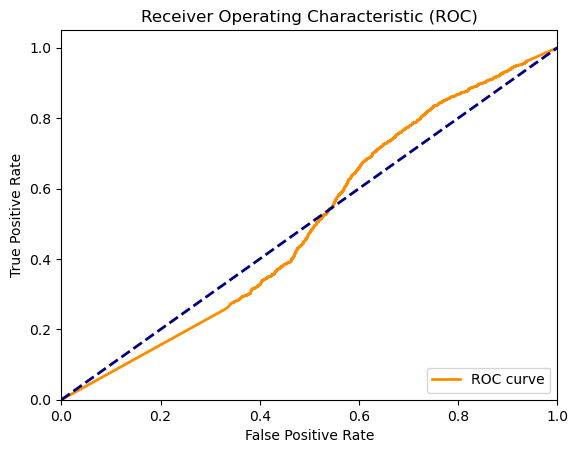

In [58]:
print("Time to reach in-sample accuracy of 0.95: {}".format(sgd_time))
y_pred = predict(X_dev, W1, b1, W2, b2)
print(classification_report(y_dev, y_pred.T[:,0]))
y_score = predict_score(X_dev, W1, b1, W2, b2)
print("roc_auc_score: {}".format(roc_auc_score(y_dev, y_score.T[:,0])))
fpr, tpr, thresholds = roc_curve(y_dev, y_score.T[:,0])
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

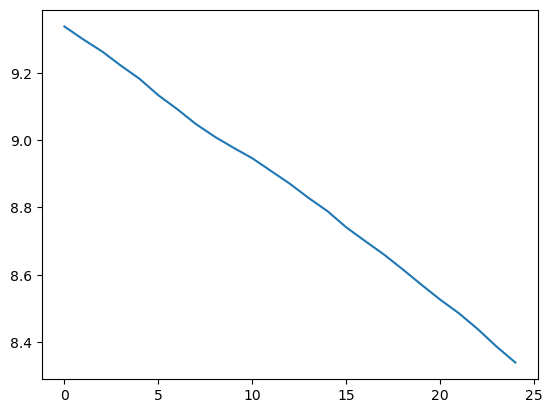

# SGD with Momentum

In [35]:
def init_v(W1, b1, W2, b2):
    vW1 = np.zeros_like(W1)
    vb1 = np.zeros_like(b1)
    vW2 = np.zeros_like(W2)
    vb2 = np.zeros_like(b2)
    return vW1, vb1, vW2, vb2

def update_params_with_momentum(W1, b1, W2, b2, dW1, db1, dW2, db2, vW1, vb1, vW2, vb2, alpha, beta):
    # Update velocities
    vW1 = beta * vW1 + (1 - beta) * dW1
    vb1 = beta * vb1 + (1 - beta) * db1
    vW2 = beta * vW2 + (1 - beta) * dW2
    vb2 = beta * vb2 + (1 - beta) * db2
    
    # Update parameters
    W1 = W1 - alpha * vW1
    b1 = b1 - alpha * vb1
    W2 = W2 - alpha * vW2
    b2 = b2 - alpha * vb2
    
    return W1, b1, W2, b2, vW1, vb1, vW2, vb2


def sgd_with_momentum(X, y, epochs, alpha, beta):
    W1, b1, W2, b2 = init_param()
    vW1, vb1, vW2, vb2 = init_v(W1, b1, W2, b2)

    m = X.shape[1]
    loss_v = np.zeros(epochs)
    for epoch in range(epochs):
        permutation = np.random.permutation(m)
        X_shuffle = X[:, permutation]
        y_shuffle = y[permutation]

        predictions = []

        #alpha = learningRateDecay(alpha, 0.01, epoch)
        
        for i in range(m):
            X_i = X_shuffle[:, i:i+1]
            y_i = y_shuffle[i:i+1]

            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_i)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X_i, y_i)
            W1, b1, W2, b2, vW1, vb1, vW2, vb2 = update_params_with_momentum(W1, b1, W2, b2, dW1, db1, \
            dW2, db2, vW1, vb1, vW2, vb2, alpha, beta)
            
            predictions.append(get_prediction(A2))

        epoch_predictions = np.concatenate(predictions, axis=1)
        epoch_accuracy = get_accuracy(epoch_predictions, y_shuffle)
        print(f"Epoch {epoch + 1}/{epochs} - Accuracy: {epoch_accuracy}")
        loss = binary_cross_entropy(y_shuffle.reshape(-1,1), epoch_predictions.reshape(-1,1))
        loss_v[epoch] = loss
        if epoch_accuracy >= 0.90:
            return W1, b1, W2, b2, loss_v
        
    return W1, b1, W2, b2, loss_v

In [36]:
sgd_momentum_start_time = time.time()
W1, b1, W2, b2, loss_momentum = sgd_with_momentum(X_train_scaled, y_train, 24, 0.1, 0.9)
sgd_momentum_end_time = time.time()
sgd_momentum_time = sgd_momentum_end_time - sgd_momentum_start_time

[[0 0 0 ... 1 1 0]] [1. 1. 1. ... 1. 1. 1.]
Epoch 1/24 - Accuracy: 0.2505888013776686


/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_50532/1481430653.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss_v[epoch] = loss


[[0 1 0 ... 0 1 0]] [1. 1. 1. ... 0. 1. 1.]
Epoch 2/24 - Accuracy: 0.3106592042950845
[[0 0 0 ... 0 0 1]] [1. 1. 1. ... 1. 1. 1.]
Epoch 3/24 - Accuracy: 0.38129004482487905
[[0 0 1 ... 0 1 1]] [0. 1. 1. ... 1. 1. 1.]
Epoch 4/24 - Accuracy: 0.45128776559373973
[[1 1 1 ... 0 0 0]] [1. 1. 1. ... 1. 1. 1.]
Epoch 5/24 - Accuracy: 0.5119659634816522
[[1 0 0 ... 0 1 1]] [1. 1. 1. ... 1. 1. 1.]
Epoch 6/24 - Accuracy: 0.5642363309443614
[[1 1 1 ... 1 0 0]] [1. 1. 1. ... 1. 1. 1.]
Epoch 7/24 - Accuracy: 0.6091878339706739
[[1 0 1 ... 1 1 1]] [1. 1. 1. ... 1. 1. 1.]
Epoch 8/24 - Accuracy: 0.6488717805860157
[[1 1 1 ... 1 1 1]] [1. 1. 1. ... 1. 1. 1.]
Epoch 9/24 - Accuracy: 0.6808569909084002
[[0 0 1 ... 1 1 0]] [1. 1. 1. ... 1. 1. 1.]
Epoch 10/24 - Accuracy: 0.7064856788310077
[[0 1 0 ... 1 1 1]] [1. 1. 1. ... 1. 0. 1.]
Epoch 11/24 - Accuracy: 0.725124724592904
[[1 1 1 ... 1 1 0]] [1. 0. 1. ... 1. 1. 1.]
Epoch 12/24 - Accuracy: 0.73887608580039
[[1 1 1 ... 1 1 0]] [1. 0. 1. ... 1. 1. 1.]
Epoch 13

Time to reach in-sample accuracy of 0.95: 137.84609484672546
              precision    recall  f1-score   support

         0.0       0.16      0.07      0.09      1194
         1.0       0.88      0.95      0.92      8677

    accuracy                           0.85      9871
   macro avg       0.52      0.51      0.50      9871
weighted avg       0.79      0.85      0.82      9871

roc_auc_score: 0.5083434053985498


/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_50532/2563048945.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-Z))
/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_50532/2563048945.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-Z))


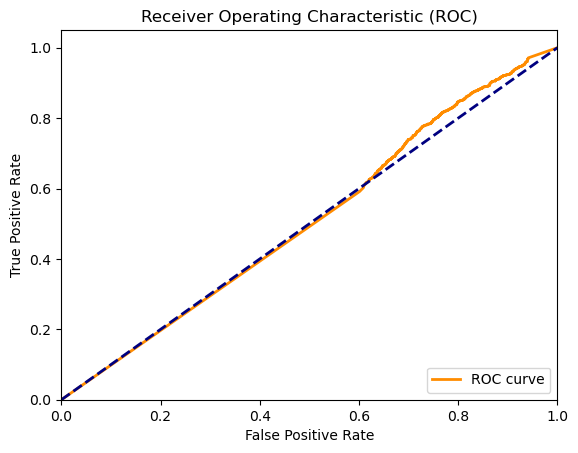

In [37]:
print("Time to reach in-sample accuracy of 0.95: {}".format(sgd_momentum_time))
y_pred = predict(X_dev, W1, b1, W2, b2)
print(classification_report(y_dev, y_pred.T[:,0]))
y_score = predict_score(X_dev, W1, b1, W2, b2)
print("roc_auc_score: {}".format(roc_auc_score(y_dev, y_score.T[:,0])))
fpr, tpr, thresholds = roc_curve(y_dev, y_score.T[:,0])
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

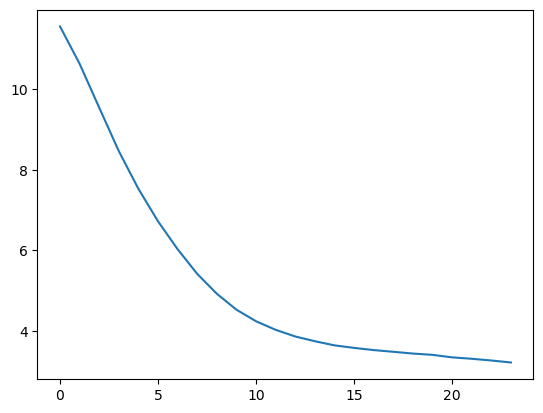

In [39]:
plt.plot(loss_momentum)

# RMSprop

In [42]:
def init_rmsp(W1, b1, W2, b2):
    sW1 = np.zeros_like(W1)
    sb1 = np.zeros_like(b1)
    sW2 = np.zeros_like(W2)
    sb2 = np.zeros_like(b2)
    return sW1, sb1, sW2, sb2

def update_params_with_rmsprop(W1, b1, W2, b2, dW1, db1, dW2, db2, sW1, sb1, sW2, sb2, alpha, beta, epsilon=1e-8):
    # Update squared gradient accumulators
    sW1 = beta * sW1 + (1 - beta) * np.square(dW1)
    sb1 = beta * sb1 + (1 - beta) * np.square(db1)
    sW2 = beta * sW2 + (1 - beta) * np.square(dW2)
    sb2 = beta * sb2 + (1 - beta) * np.square(db2)
    
    # Update parameters
    W1 -= alpha * dW1 / (np.sqrt(sW1) + epsilon)
    b1 -= alpha * db1 / (np.sqrt(sb1) + epsilon)
    W2 -= alpha * dW2 / (np.sqrt(sW2) + epsilon)
    b2 -= alpha * db2 / (np.sqrt(sb2) + epsilon)
    
    return W1, b1, W2, b2, sW1, sb1, sW2, sb2

def sgd_with_RMSProp(X, y, epochs, alpha, beta):
    W1, b1, W2, b2 = init_param()
    sW1, sb1, sW2, sb2 = init_rmsp(W1, b1, W2, b2)

    m = X.shape[1]
    loss_v = np.zeros(epochs)
    for epoch in range(epochs):
        permutation = np.random.permutation(m)
        X_shuffle = X[:, permutation]
        y_shuffle = y[permutation]

        predictions = []

        #alpha = learningRateDecay(alpha, 0.01, epoch)
        
        for i in range(m):
            X_i = X_shuffle[:, i:i+1]
            y_i = y_shuffle[i:i+1]

            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_i)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X_i, y_i)
            W1, b1, W2, b2, vW1, vb1, vW2, vb2 = update_params_with_rmsprop(W1, b1, W2, b2, dW1, db1, \
            dW2, db2, sW1, sb1, sW2, sb2, alpha, beta)
            
            predictions.append(get_prediction(A2))
        
        epoch_predictions = np.concatenate(predictions, axis=1)
        epoch_accuracy = get_accuracy(epoch_predictions, y_shuffle)
        
        loss = binary_cross_entropy(y_shuffle.reshape(-1,1), epoch_predictions.reshape(-1,1))
        loss_v[epoch] = loss
        print(f"Epoch {epoch + 1}/{epochs} - Accuracy: {epoch_accuracy} - loss:{loss}")
    return W1, b1, W2, b2, loss_v

In [71]:
alpha = 0.01
beta = 0.9
n_epochs = 2

start_time = time.time()
W1, b1, W2, b2, loss_rmsprop = sgd_with_RMSProp(X_train_scaled, y_train, n_epochs, alpha, beta)
end_time = time.time()
sgd_rmsprop_time = end_time - start_time

[[1 1 0 ... 1 0 1]] [1. 1. 1. ... 1. 0. 1.]
Epoch 1/2 - Accuracy: 0.9944032213133436 - loss:[0.08633002]


/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_50532/3605107938.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss_v[epoch] = loss


[[1 1 1 ... 1 1 1]] [1. 1. 1. ... 1. 1. 1.]
Epoch 2/2 - Accuracy: 0.9985818117355079 - loss:[0.02187548]


Time to reach in-sample accuracy of 0.95: 19.392911195755005
              precision    recall  f1-score   support

         0.0       0.52      0.03      0.06      1194
         1.0       0.88      1.00      0.94      8677

    accuracy                           0.88      9871
   macro avg       0.70      0.51      0.50      9871
weighted avg       0.84      0.88      0.83      9871

roc_auc_score: 0.5277947495535376


/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_50532/2563048945.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-Z))
/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_50532/2563048945.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-Z))


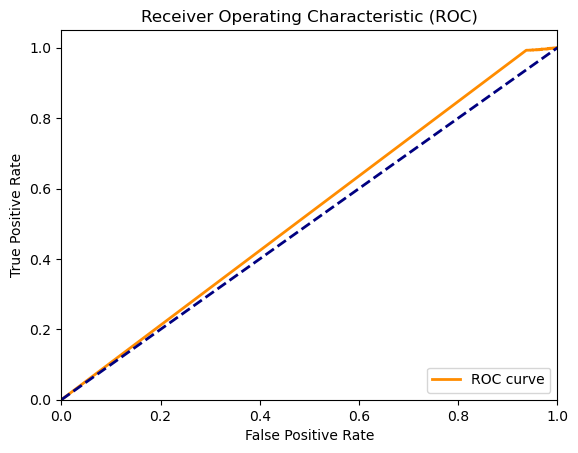

In [72]:
print("Time to reach in-sample accuracy of 0.95: {}".format(sgd_rmsprop_time))
y_pred = predict(X_dev, W1, b1, W2, b2)
print(classification_report(y_dev, y_pred.T[:,0]))
y_score = predict_score(X_dev, W1, b1, W2, b2)
print("roc_auc_score: {}".format(roc_auc_score(y_dev, y_score.T[:,0])))
fpr, tpr, thresholds = roc_curve(y_dev, y_score.T[:,0])
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

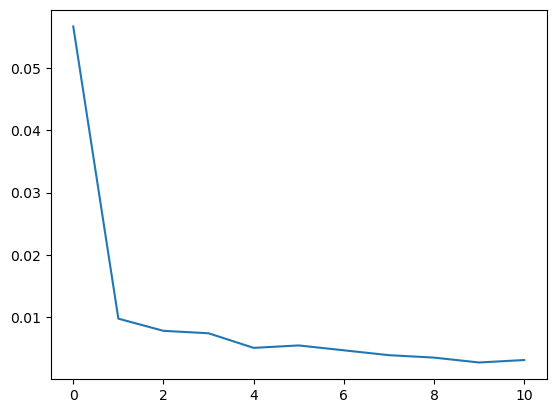

In [46]:
plt.plot(loss_rmsprop)

# ADAM

In [50]:
def init_adam(W1, b1, W2, b2):
    # First moment vectors
    mW1 = np.zeros_like(W1)
    mb1 = np.zeros_like(b1)
    mW2 = np.zeros_like(W2)
    mb2 = np.zeros_like(b2)
    
    # Second moment vectors
    vW1 = np.zeros_like(W1)
    vb1 = np.zeros_like(b1)
    vW2 = np.zeros_like(W2)
    vb2 = np.zeros_like(b2)
    
    return mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2

def update_with_ADAM(W1, b1, W2, b2, dW1, db1, dW2, db2, mW1, mb1, mW2, mb2, 
                     vW1, vb1, vW2, vb2, t, alpha, beta1, beta2, epsilon=1e-8):

    mW1 = beta1 * mW1 + (1 - beta1) * dW1
    mb1 = beta1 * mb1 + (1 - beta1) * db1
    mW2 = beta1 * mW2 + (1 - beta1) * dW2
    mb2 = beta1 * mb2 + (1 - beta1) * db2

    # Correcting the square of gradients
    vW1 = beta2 * vW1 + (1 - beta2) * (dW1 ** 2)
    vb1 = beta2 * vb1 + (1 - beta2) * (db1 ** 2)
    vW2 = beta2 * vW2 + (1 - beta2) * (dW2 ** 2)
    vb2 = beta2 * vb2 + (1 - beta2) * (db2 ** 2)

    # First moment correction
    mW1_corrected = mW1 / (1 - beta1 ** t)
    mb1_corrected = mb1 / (1 - beta1 ** t)
    mW2_corrected = mW2 / (1 - beta1 ** t)
    mb2_corrected = mb2 / (1 - beta1 ** t)

    # Second moment correction
    vW1_corrected = vW1 / (1 - beta2 ** t)
    vb1_corrected = vb1 / (1 - beta2 ** t)
    vW2_corrected = vW2 / (1 - beta2 ** t)
    vb2_corrected = vb2 / (1 - beta2 ** t)

    # Parameter updates
    W1 -= alpha * mW1_corrected / (np.sqrt(vW1_corrected) + epsilon)
    b1 -= alpha * mb1_corrected / (np.sqrt(vb1_corrected) + epsilon)
    W2 -= alpha * mW2_corrected / (np.sqrt(vW2_corrected) + epsilon)
    b2 -= alpha * mb2_corrected / (np.sqrt(vb2_corrected) + epsilon)
    
    return W1, b1, W2, b2, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2

def sgd_with_adam(X, y, epochs, alpha, beta1, beta2):
    W1, b1, W2, b2 = init_param()
    mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2 = init_adam(W1, b1, W2, b2)

    m = X.shape[1]
    t = 1
    loss_v = np.zeros(epochs)
    for epoch in range(epochs):
        permutation = np.random.permutation(m)
        X_shuffle = X[:, permutation]
        y_shuffle = y[permutation]

        predictions = []
        #alpha = learningRateDecay(alpha, 0.01, epoch)
        
        for i in range(m):
            X_i = X_shuffle[:, i:i+1]
            y_i = y_shuffle[i:i+1]

            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_i)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X_i, y_i)
            W1, b1, W2, b2, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2 = update_with_ADAM(W1, b1, W2, b2, dW1, db1, dW2, db2, mW1, mb1, mW2, mb2, 
                     vW1, vb1, vW2, vb2, t, alpha, beta1, beta2)
            
            predictions.append(get_prediction(A2))
            
            t += 1
            
        epoch_predictions = np.concatenate(predictions, axis=1)
        epoch_accuracy = get_accuracy(epoch_predictions, y_shuffle)
        loss = binary_cross_entropy(y_shuffle.reshape(-1,1), epoch_predictions.reshape(-1,1))
        loss_v[epoch] = loss
        print(f"Epoch {epoch + 1}/{epochs} - Accuracy: {epoch_accuracy} - loss: {loss}")
        
    return W1, b1, W2, b2, loss_v




In [51]:
alpha = 0.01
beta1 = 0.9
beta2 = 0.9
n_epochs = 11

start_time = time.time()
W1, b1, W2, b2, loss_adam= sgd_with_adam(X_train_scaled, y_train, n_epochs, alpha, beta1, beta2)
end_time = time.time()
sgd_adam_time = end_time - start_time

[[0 0 0 ... 1 1 0]] [1. 1. 1. ... 1. 1. 0.]
Epoch 1/11 - Accuracy: 0.9953402385595259 - loss: [0.07187658]


/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_50532/262861874.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss_v[epoch] = loss


[[0 1 1 ... 1 1 1]] [0. 1. 1. ... 1. 1. 1.]
Epoch 2/11 - Accuracy: 0.9996961025147517 - loss: [0.0046876]
[[1 1 1 ... 1 1 1]] [1. 1. 1. ... 1. 1. 1.]
Epoch 3/11 - Accuracy: 0.9997467520956264 - loss: [0.00390634]
[[1 1 1 ... 0 1 1]] [1. 1. 1. ... 0. 1. 1.]
Epoch 4/11 - Accuracy: 0.9996961025147517 - loss: [0.0046876]
[[1 1 1 ... 1 1 1]] [1. 1. 1. ... 1. 1. 1.]
Epoch 5/11 - Accuracy: 0.9997467520956264 - loss: [0.00390634]
[[1 1 1 ... 1 1 0]] [1. 1. 1. ... 1. 1. 0.]
Epoch 6/11 - Accuracy: 0.9997467520956264 - loss: [0.00390634]
[[0 1 1 ... 1 0 1]] [0. 1. 1. ... 1. 0. 1.]
Epoch 7/11 - Accuracy: 0.9997214273051891 - loss: [0.00429697]
[[1 1 1 ... 1 1 1]] [1. 1. 1. ... 1. 1. 1.]
Epoch 8/11 - Accuracy: 0.9997214273051891 - loss: [0.00429697]
[[1 1 0 ... 1 1 0]] [1. 1. 0. ... 1. 1. 0.]
Epoch 9/11 - Accuracy: 0.9997720768860637 - loss: [0.0035157]
[[1 1 1 ... 1 1 1]] [1. 1. 1. ... 1. 1. 1.]
Epoch 10/11 - Accuracy: 0.9998480512573759 - loss: [0.0023438]
[[1 1 1 ... 0 1 1]] [1. 1. 1. ... 0. 1. 

Time to reach in-sample accuracy of 0.95: 105.7257730960846
              precision    recall  f1-score   support

         0.0       0.83      0.06      0.11      1194
         1.0       0.88      1.00      0.94      8677

    accuracy                           0.88      9871
   macro avg       0.86      0.53      0.52      9871
weighted avg       0.88      0.88      0.84      9871

roc_auc_score: 0.5530744749833452


/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_50532/2563048945.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-Z))
/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_50532/2563048945.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-Z))


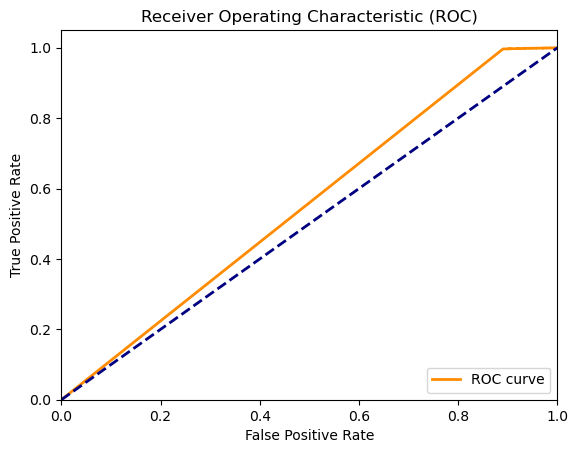

In [52]:
print("Time to reach in-sample accuracy of 0.95: {}".format(sgd_adam_time))
y_pred = predict(X_dev, W1, b1, W2, b2)
print(classification_report(y_dev, y_pred.T[:,0]))
y_score = predict_score(X_dev, W1, b1, W2, b2)
print("roc_auc_score: {}".format(roc_auc_score(y_dev, y_score.T[:,0])))
fpr, tpr, thresholds = roc_curve(y_dev, y_score.T[:,0])
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

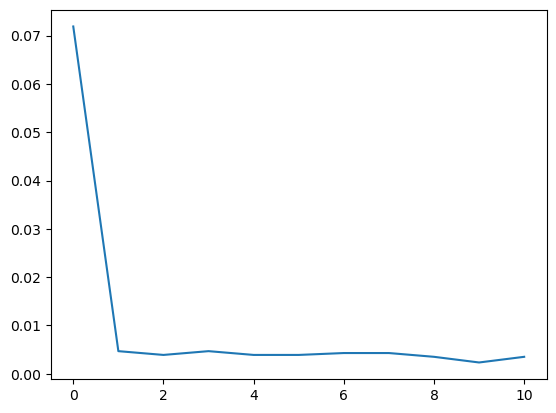

In [54]:
plt.plot(loss_adam)

# Gradient Descent

In [16]:
def gradient_descent(X, y, iterations, alpha):
    W1, b1, W2, b2 = init_param()

    
    for i in range(iterations):
        alpha = learningRateDecay(alpha, 0.00001, i)
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X, y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 50 == 0:
            print("Iteration:", i)
            print("Accuracy:", get_accuracy(get_prediction(A2), y))
            
            loss = binary_cross_entropy(y.reshape(-1,1), get_prediction(A2).reshape(-1,1))
            print(loss)
    return W1, b1, W2, b2

In [17]:
W1, b1, W2, b2 = gradient_descent(X_train_scaled, y_train, 150, 0.01)

Iteration: 0
[[1 1 1 ... 1 1 1]] [1. 1. 1. ... 1. 1. 1.]
Accuracy: 0.6284346747030668
[5.731376]
Iteration: 50
[[1 1 1 ... 1 1 1]] [1. 1. 1. ... 1. 1. 1.]
Accuracy: 0.7306455289082483
[4.15477884]
Iteration: 100
[[1 1 1 ... 1 1 1]] [1. 1. 1. ... 1. 1. 1.]
Accuracy: 0.778509382834857
[3.41648136]


              precision    recall  f1-score   support

         0.0       0.33      0.01      0.02      1114
         1.0       0.89      1.00      0.94      8757

    accuracy                           0.89      9871
   macro avg       0.61      0.50      0.48      9871
weighted avg       0.83      0.89      0.84      9871

roc_auc_score: 0.5422897383555069


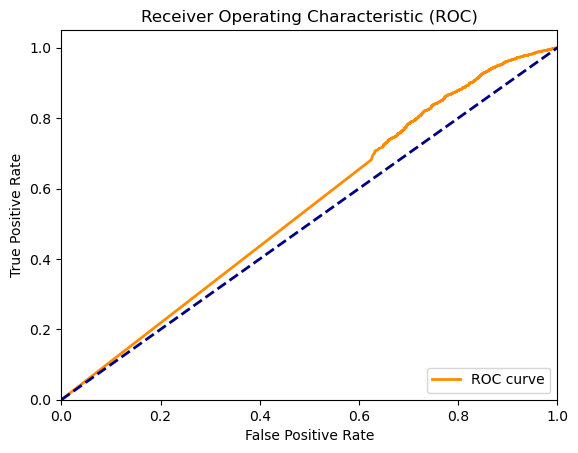

In [28]:
y_pred = predict(X_dev, W1, b1, W2, b2)
print(classification_report(y_dev, y_pred.T[:,0]))
y_score = predict_score(X_dev, W1, b1, W2, b2)
print("roc_auc_score: {}".format(roc_auc_score(y_dev, y_score.T[:,0])))
fpr, tpr, thresholds = roc_curve(y_dev, y_score.T[:,0])
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

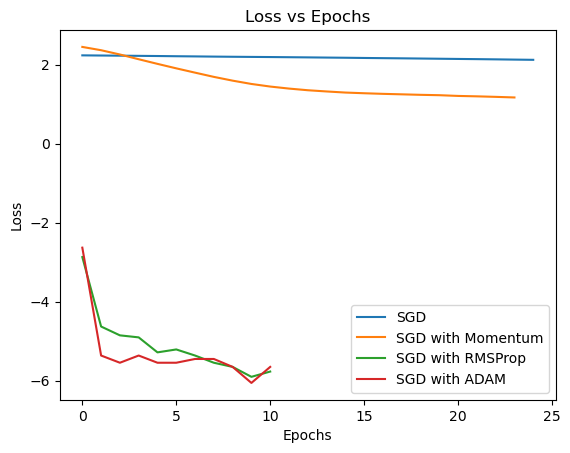

In [70]:
plt.plot(np.log(loss_sgd), label = "SGD")
plt.plot(np.log(loss_momentum), label = "SGD with Momentum")
plt.plot(np.log(loss_rmsprop), label = "SGD with RMSProp")
plt.plot(np.log(loss_adam), label = "SGD with ADAM")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.savefig("Loss_Epochs.pdf")
plt.show()